In [1]:
import astropy.units as u
from astropy.visualization import quantity_support
quantity_support()
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord

import numpy as np
import pandas as pd
import gala.dynamics as gd
import gala.units as gu

import kicker

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

In [5]:
from isochrones.mist.bc import MISTBolometricCorrectionGrid

In [8]:
bc_grid = MISTBolometricCorrectionGrid(bands=['J', 'H', 'K', 'G', 'BP', 'RP'])

In [17]:
p = kicker.pop.load("data/recent-pop")

In [82]:
zero_point_lum = 3.0128e28 * u.watt

# Load in the populations

In [10]:
class RecentHistory(kicker.galaxy.Frankel2018):
    def __init__(self, components=["low_alpha_disc"], component_masses=[1], **kwargs):
        super().__init__(components=components, component_masses=component_masses, **kwargs)

    def draw_lookback_times(self, size=None, component="low_alpha_disc"):
        if component != "low_alpha_disc":
            raise NotImplementedError()

        U = np.random.rand(size)
        norm = 1 / (self.tsfr * np.exp(-self.galaxy_age / self.tsfr) * (np.exp(200 * u.Myr / self.tsfr) - 1))
        tau = self.tsfr * np.log((U * np.exp(self.galaxy_age / self.tsfr)) / (norm * self.tsfr) + 1)

        return tau

In [4]:
p_list = [kicker.pop.load(f"data/pop-{i}") for i in range(5)]

In [5]:
for p in p_list:
    p.classes

# Get some of the final distributions

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    [(163.6065414 ,  61.96493464,    9.70990997),
     (230.39757242, -21.05595832, 3472.4464684 ),
     (275.89194418,  14.97515969,   15.46280133), ...,
     (221.33502951, -51.65846668,    8.16492653),
     (233.878825  , -29.3362076 ,    5.2157425 ),
     ( 54.19084057, -47.59609796,   11.64527629)]
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(-2.9704062 , -6.35256907e+00, -169.73413845),
     (-0.01003822, -1.06703256e-02,  404.18682673),
     (-3.53367772, -1.04177564e-01, -110.2888967 ), ...,
     (-2.62654257, -1.42017107e+00,  338.30154824),
     ( 1.91970317, -1.12344522e+01,  248.76304951),
     ( 2.8145896 , -2.32560439e+00,  171.44688768)]>

In [22]:
p.initial_galaxy.__class__.__bases__

(kicker.galaxy.Galaxy,)

In [10]:
for p in p_list:
    p.final_bpp = p.bpp[~p.bpp.index.duplicated(keep="last")]
    
    # get final positions and velocities
    final_kinematics = np.zeros((len(p.orbits), 2, 6))
    for i, orbit in enumerate(p.orbits):
        if isinstance(orbit, list):
            final_kinematics[i, 0, :3] = orbit[0][-1].pos.xyz.to(u.kpc).value
            final_kinematics[i, 1, :3] = orbit[1][-1].pos.xyz.to(u.kpc).value
            final_kinematics[i, 0, 3:] = orbit[0][-1].vel.d_xyz.to(u.km / u.s)
            final_kinematics[i, 1, 3:] = orbit[1][-1].vel.d_xyz.to(u.km / u.s)
        else:
            final_kinematics[i, 0, :3] = orbit[-1].pos.xyz.to(u.kpc).value
            final_kinematics[i, 0, 3:] = orbit[-1].vel.d_xyz.to(u.km / u.s)
            
    for i in [1, 2]:
        df = pd.DataFrame(final_kinematics[:, i - 1, :], columns=[f"x_{i}", f"y_{i}", f"z_{i}",
                                                                  f"v_x_{i}", f"v_y_{i}", f"v_z_{i}"])
        df.index = p.final_bpp.index
        p.final_bpp = p.final_bpp.join(df)

In [25]:
def grid_plot(x_var, y_var, x_label, y_label):
    fig, axes = plt.subplots(2, 2, figsize=(20, 20), gridspec_kw={"width_ratios": [3, 1], "height_ratios": [1, 3]})

    fig.subplots_adjust(hspace=0.0, wspace=0.0)

    disrupted = final_binaries["sep"] < 0
    kicked = final_binaries.index.isin(kicked_nums)

    axes[1, 0].scatter(np.abs(final_binaries[f"{x_var}_1"][~kicked]), np.abs(final_binaries[f"{y_var}_1"][~kicked]), s=5, label=f"No supernova ({len(final_binaries[~kicked])})")

    axes[1, 0].scatter(np.abs(final_binaries[f"{x_var}_1"][kicked]), np.abs(final_binaries[f"{y_var}_1"][kicked]), s=10, color="C1", label=f"At least 1 supernova ({len(final_binaries[kicked])})")
    axes[1, 0].scatter(np.abs(final_binaries[f"{x_var}_2"][kicked & disrupted]), np.abs(final_binaries[f"{y_var}_2"][kicked & disrupted]), s=5, color="C1")

    axes[1, 0].set_xscale("log")
    axes[1, 0].set_yscale("log")

    axes[1, 0].set_xlabel(x_label)
    axes[1, 0].set_ylabel(y_label)

    axes[1, 0].legend(fontsize=0.7*fs, markerscale=5, handletextpad=0.0)

    axes[0, 1].axis("off")

    x_bins = np.logspace(np.log10(np.abs(final_binaries[f"{x_var}_1"]).min()), np.log10(np.abs(final_binaries[f"{x_var}_1"]).max()), 50)
    axes[0, 0].hist(np.abs(final_binaries[f"{x_var}_1"][~kicked]), bins=x_bins, log=True)
    axes[0, 0].hist(np.abs(np.concatenate((final_binaries[f"{x_var}_1"][kicked], final_binaries[f"{x_var}_2"][kicked]))), bins=x_bins, log=True, alpha=0.5)
    axes[0, 0].set_xscale("log")
    axes[0, 0].set_xticks([])
    axes[0, 0].set_ylabel(r"$N_{\rm binary}$")

    y_bins = np.logspace(np.log10(np.abs(final_binaries[f"{y_var}_1"]).min()), np.log10(np.abs(final_binaries[f"{y_var}_1"]).max()), 50)
    axes[1, 1].hist(np.abs(final_binaries[f"{y_var}_1"][~kicked]), bins=y_bins, orientation="horizontal", log=True)
    axes[1, 1].hist(np.abs(np.concatenate((final_binaries[f"{y_var}_1"][kicked], final_binaries[f"{y_var}_2"][kicked]))), bins=y_bins, orientation="horizontal", log=True, alpha=0.5)
    axes[1, 1].set_yscale("log")
    axes[1, 1].set_yticks([])
    axes[1, 1].set_xlabel(r"$N_{\rm binary}$")

    plt.show()

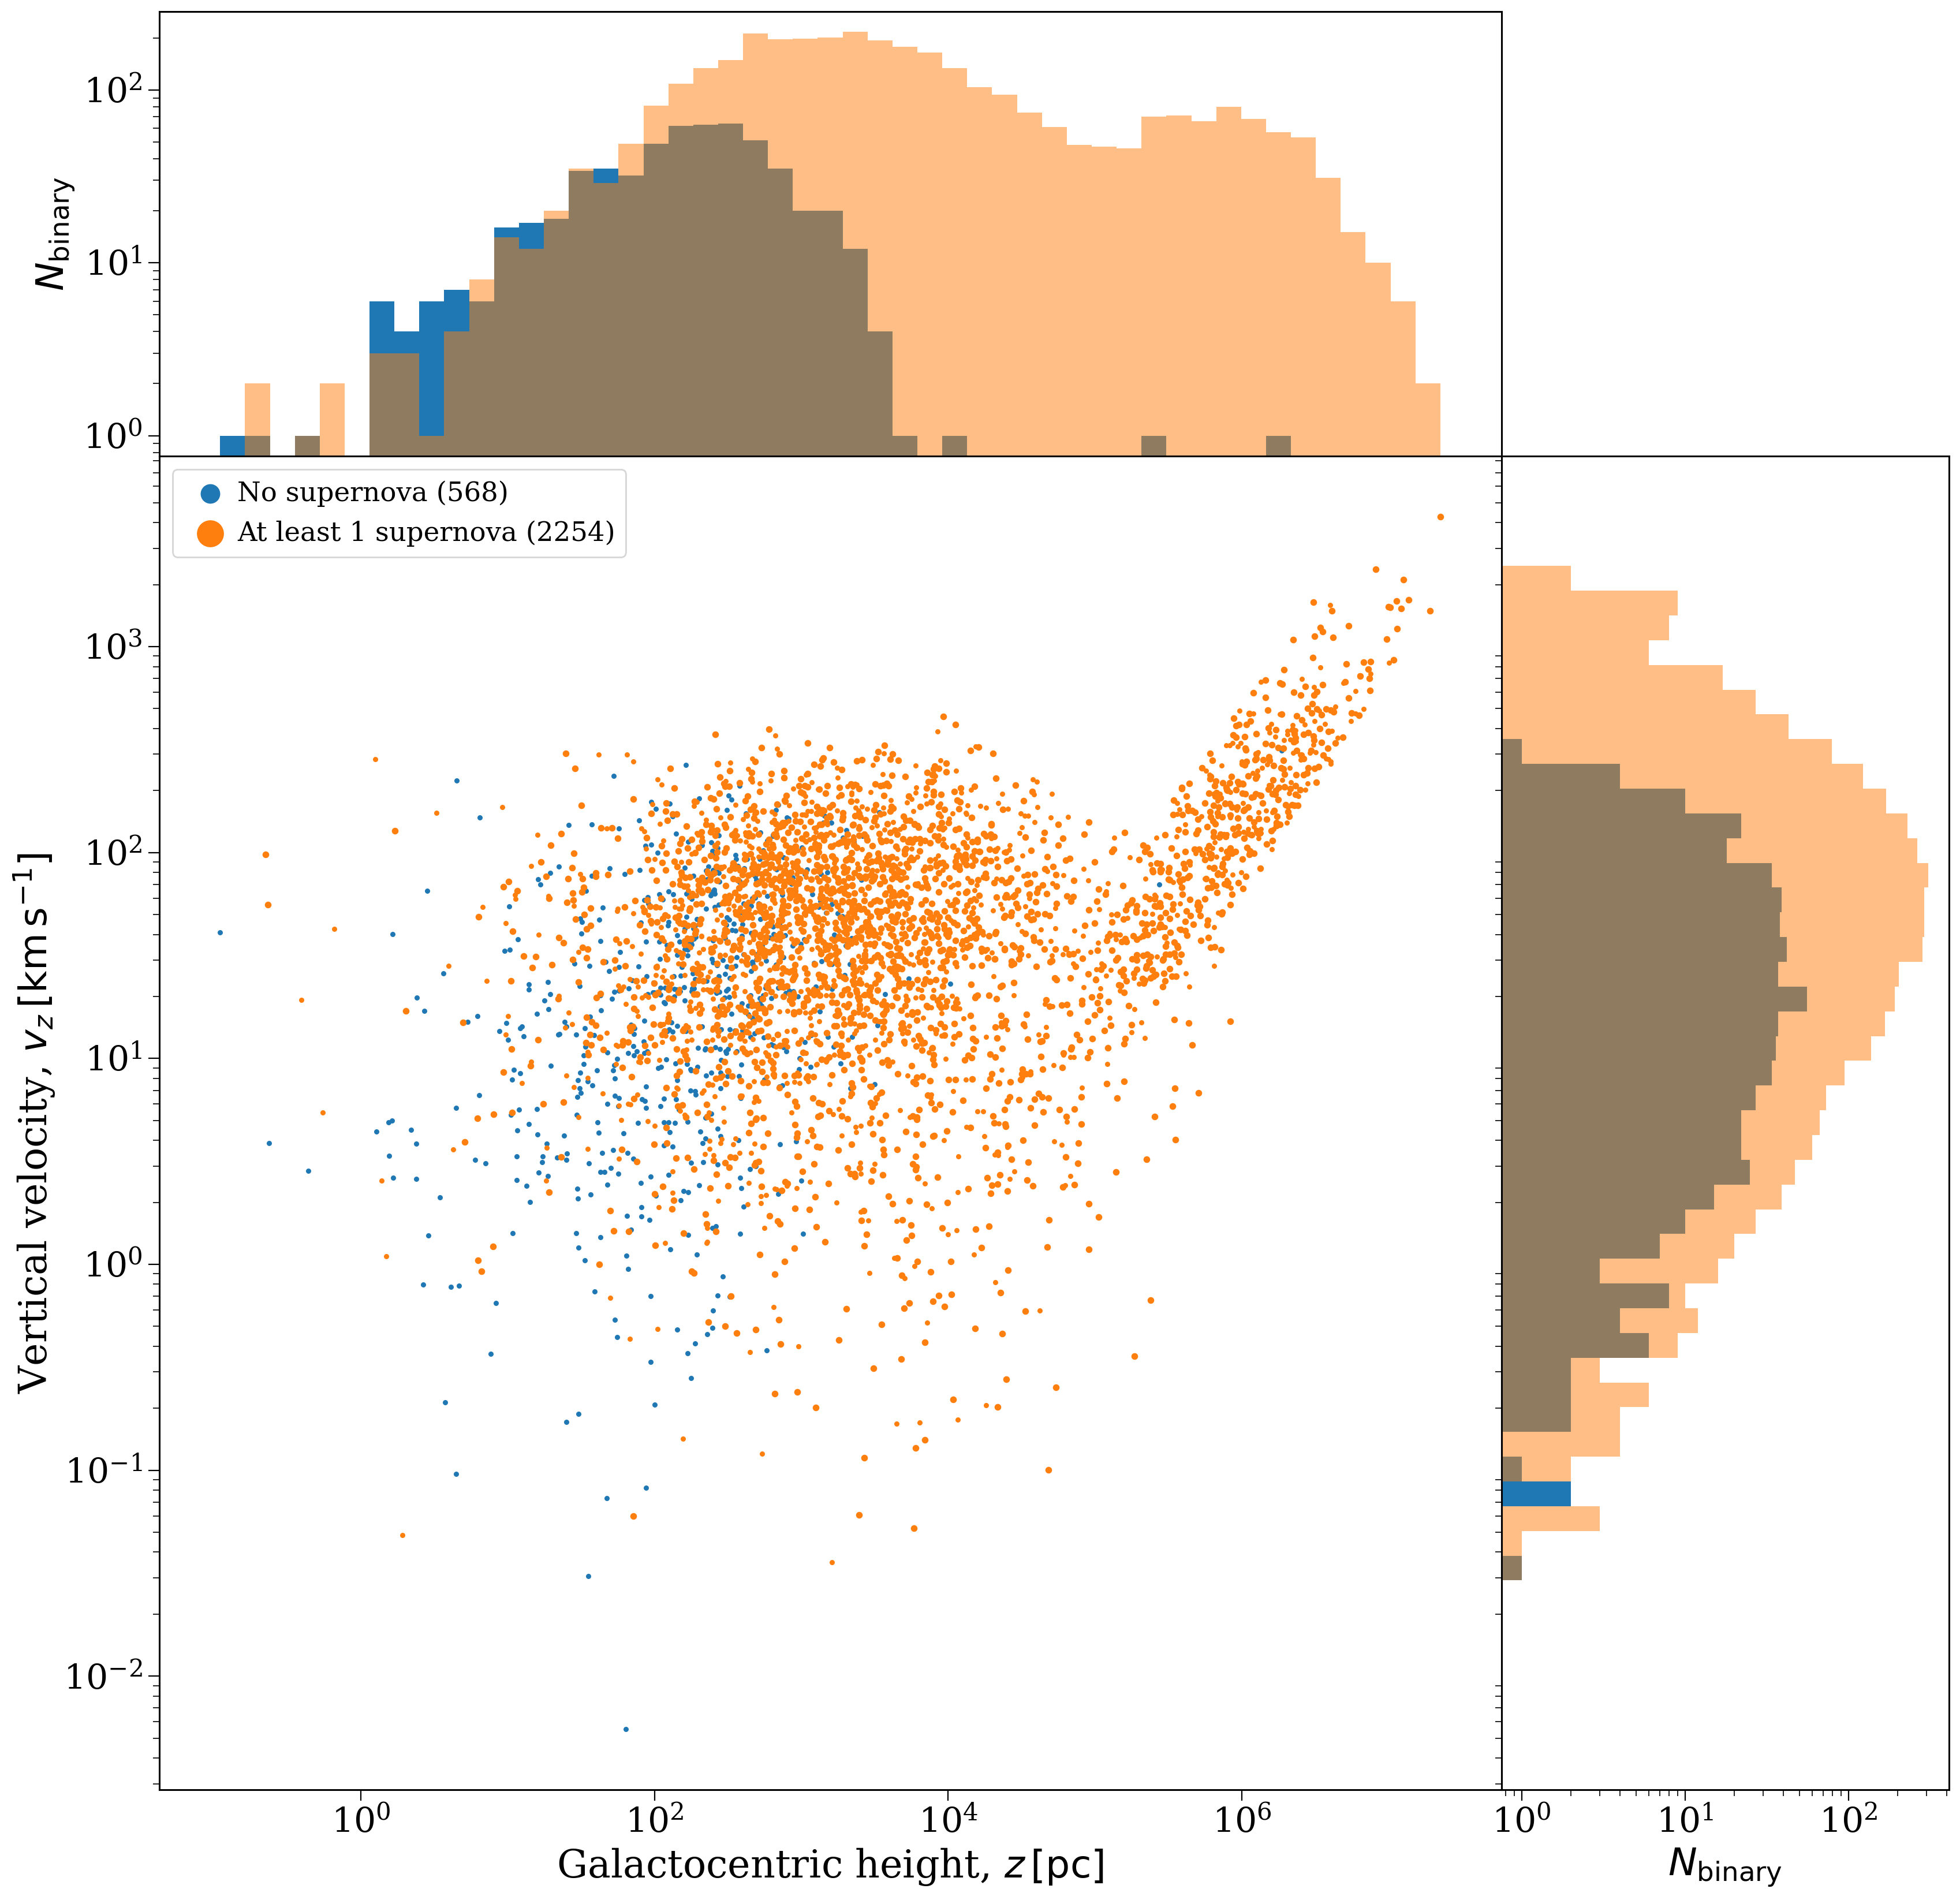

In [17]:
grid_plot("z", "v_z", r"Galactocentric height, $z\,[\rm pc]$", r"Vertical velocity, $v_z\,[\rm km \, s^{-1}]$")

In [18]:
for ind in [1, 2]:
    final_binaries[f"dist_{ind}"] = np.sqrt(final_binaries[f"x_{ind}"]**2 + final_binaries[f"y_{ind}"]**2 + final_binaries[f"z_{ind}"]**2)
    final_binaries[f"speed_{ind}"] = np.sqrt(final_binaries[f"v_x_{ind}"]**2 + final_binaries[f"v_y_{ind}"]**2 + final_binaries[f"v_z_{ind}"]**2)

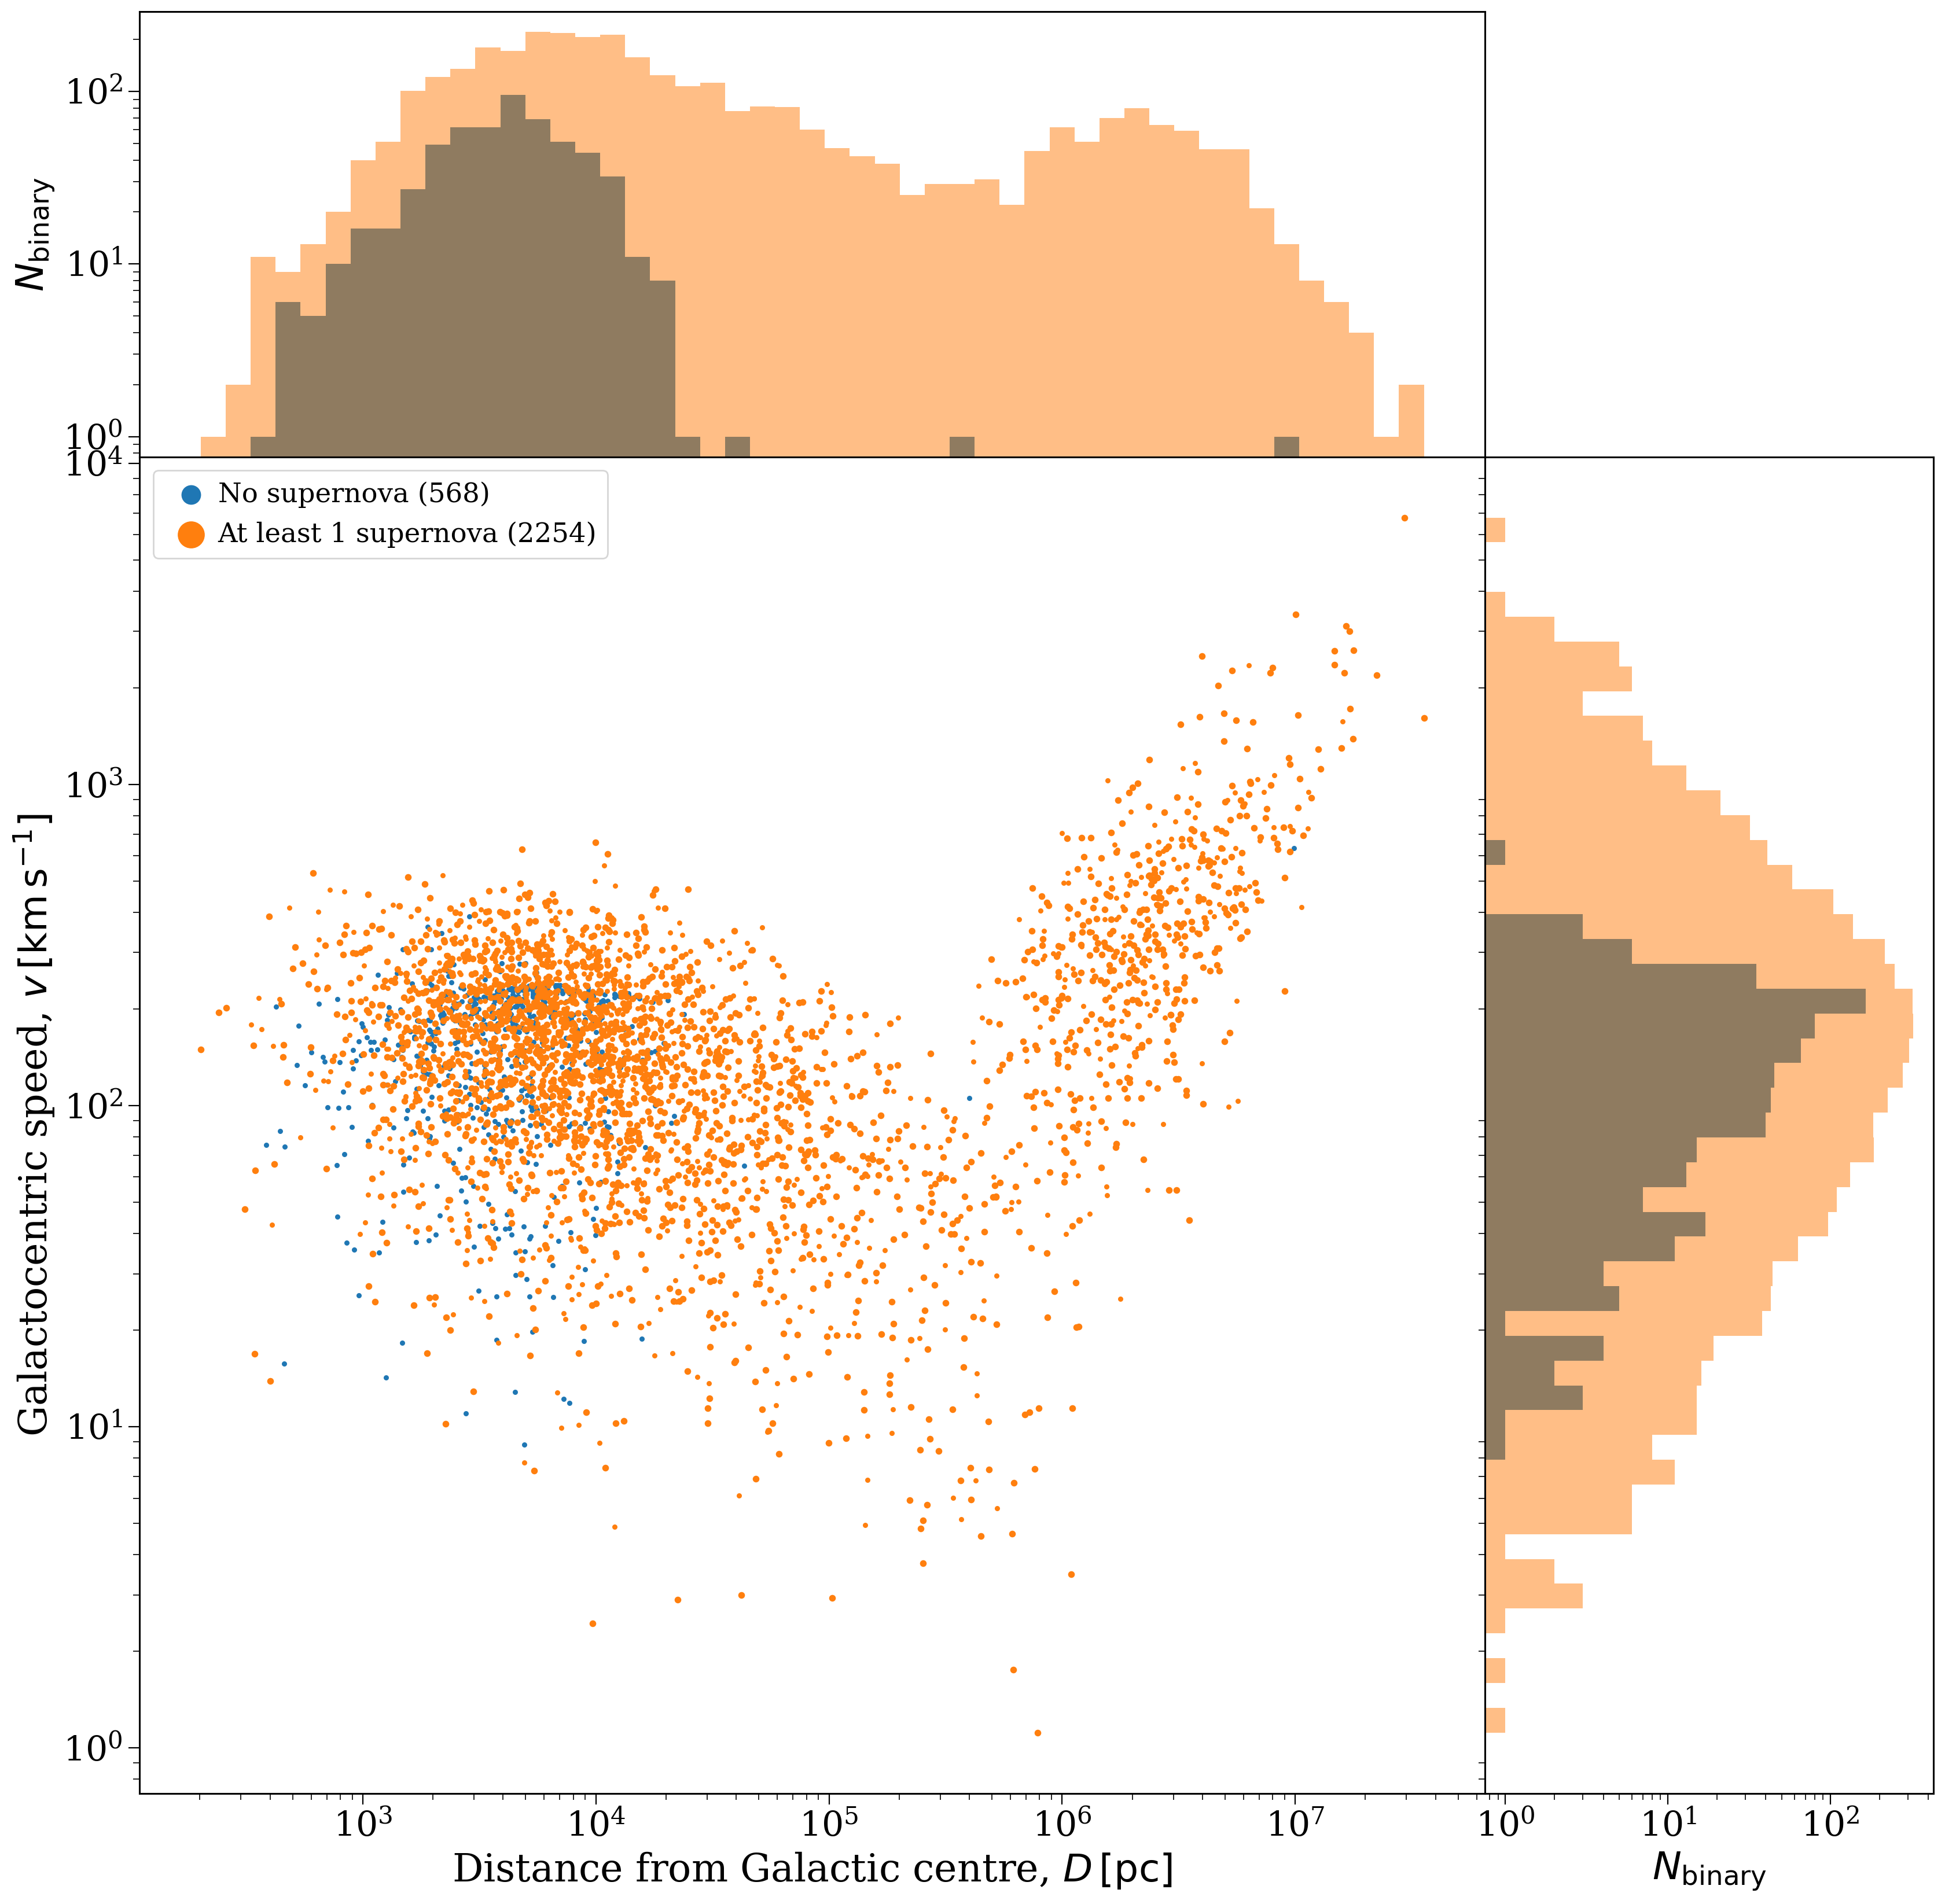

In [23]:
grid_plot("dist", "speed", r"Distance from Galactic centre, $D\,[\rm pc]$", r"Galactocentric speed, $v\,[\rm km \, s^{-1}]$")

In [20]:
def grid_plot_by_mass(x_var, y_var, x_label, y_label, mass_lims=[0.0, 0.1, 1.5, 7.0, 20, np.inf], sizes=[1, 1, 10, 10, 10]):
    fig, axes = plt.subplots(2, 2, figsize=(20, 20), gridspec_kw={"width_ratios": [3, 1], "height_ratios": [1, 3]})

    fig.subplots_adjust(hspace=0.0, wspace=0.0)

    disrupted = final_binaries["sep"] < 0

    x_bins = np.logspace(np.log10(np.abs(final_binaries[f"{x_var}_1"]).min()), np.log10(np.abs(final_binaries[f"{x_var}_1"]).max()), 50)
    y_bins = np.logspace(np.log10(np.abs(final_binaries[f"{y_var}_1"]).min()), np.log10(np.abs(final_binaries[f"{y_var}_1"]).max()), 50)
    for i in range(len(mass_lims) - 1):
        mass_mask = ((p.initial_binaries["mass_1"] >= mass_lims[i]) & (p.initial_binaries["mass_1"] < mass_lims[i + 1])).values
        label = f"{mass_lims[i]} " + r"$\leq m_{1, i} <$" + f" {mass_lims[i + 1]}   ({len(final_binaries[mass_mask])})"
        axes[1, 0].scatter(np.abs(final_binaries[f"{x_var}_1"][mass_mask]), np.abs(final_binaries[f"{y_var}_1"][mass_mask]), s=sizes[i], label=label)
        axes[0, 0].hist(np.abs(final_binaries[f"{x_var}_1"][mass_mask]), bins=x_bins, log=True, histtype="step")
        axes[1, 1].hist(np.abs(final_binaries[f"{y_var}_1"][mass_mask]), bins=y_bins, orientation="horizontal", log=True, histtype="step")

    axes[1, 0].set_xscale("log")
    axes[1, 0].set_yscale("log")

    axes[1, 0].set_xlabel(x_label)
    axes[1, 0].set_ylabel(y_label)

    axes[1, 0].legend(fontsize=0.7*fs, markerscale=5, handletextpad=0.0)

    axes[0, 1].axis("off")
    
    axes[0, 0].set_xscale("log")
    axes[0, 0].set_xticks([])
    axes[0, 0].set_ylabel(r"$N_{\rm binary}$")

    # axes[1, 1].hist(np.abs(final_binaries[f"{y_var}_1"][~kicked]), bins=y_bins, orientation="horizontal", log=True)
    # axes[1, 1].hist(np.abs(np.concatenate((final_binaries[f"{y_var}_1"][kicked], final_binaries[f"{y_var}_2"][kicked]))), bins=y_bins, orientation="horizontal", log=True, alpha=0.5)
    axes[1, 1].set_yscale("log")
    axes[1, 1].set_yticks([])
    axes[1, 1].set_xlabel(r"$N_{\rm binary}$")

    plt.show()

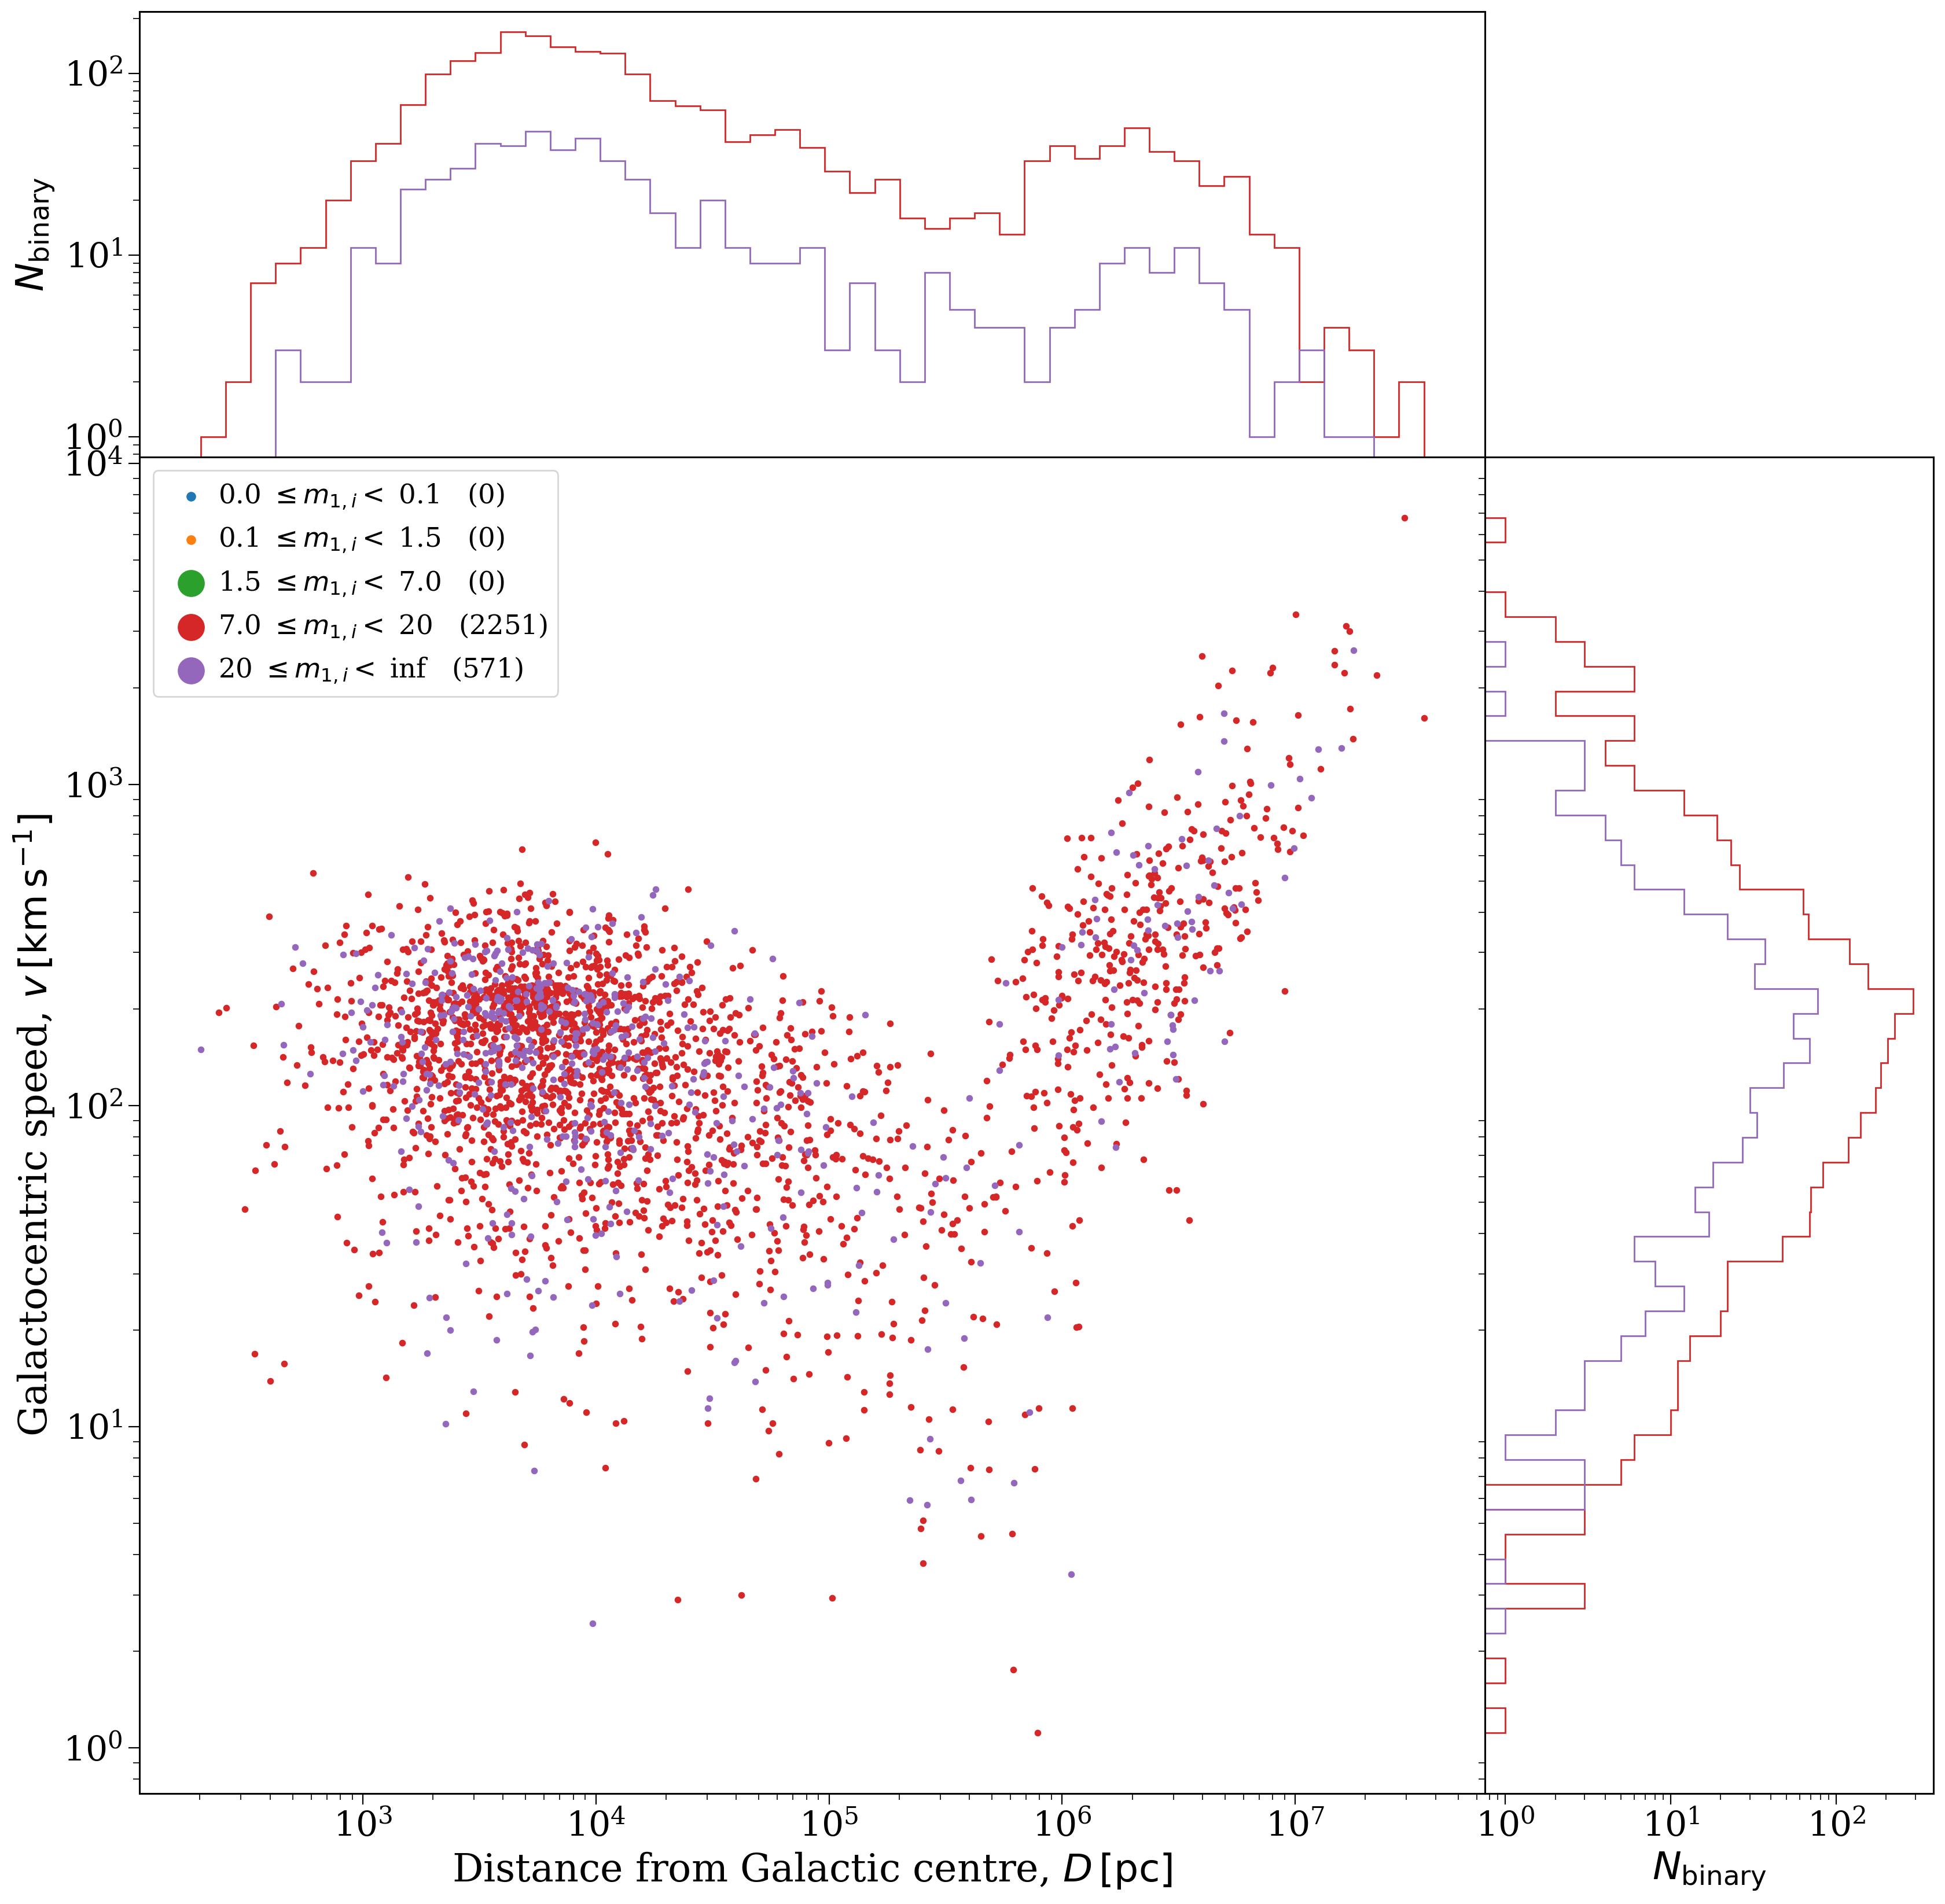

In [22]:
grid_plot_by_mass("dist", "speed", r"Distance from Galactic centre, $D\,[\rm pc]$", r"Galactocentric speed, $v\,[\rm km \, s^{-1}]$")

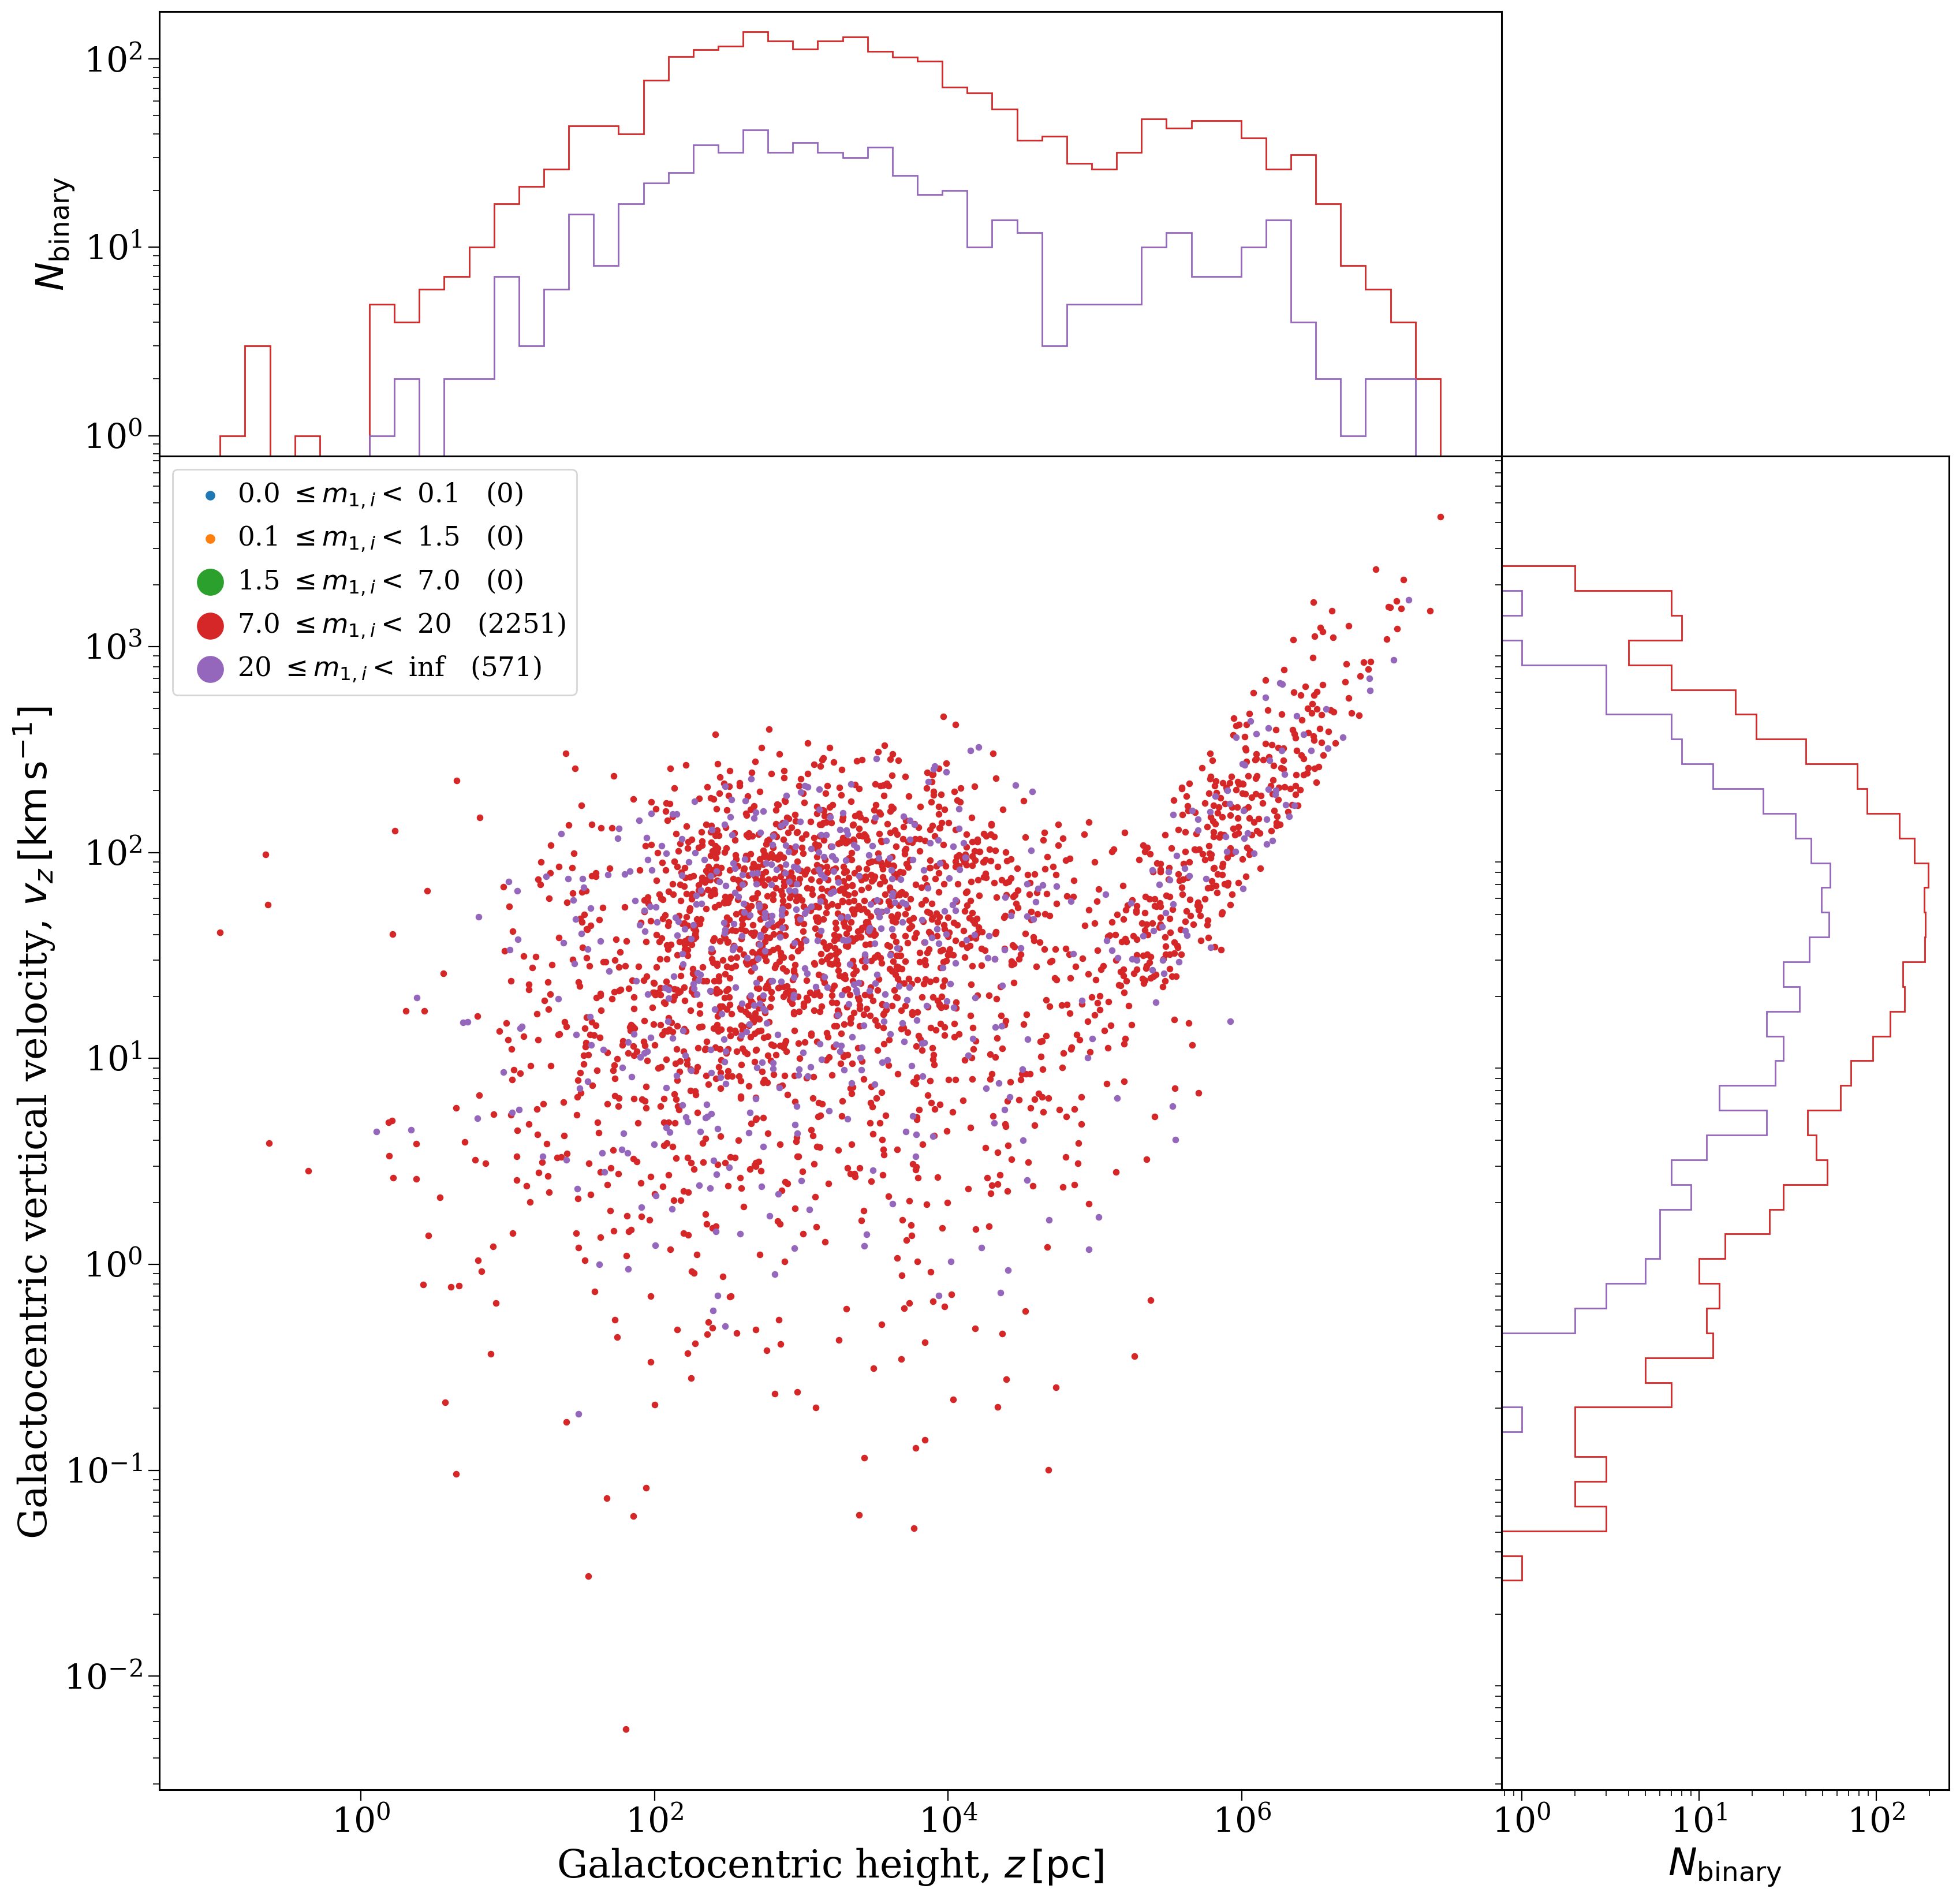

In [24]:
grid_plot_by_mass("z", "v_z", r"Galactocentric height, $z\,[\rm pc]$", r"Galactocentric vertical velocity, $v_z\,[\rm km \, s^{-1}]$")